In [1]:
from tsfresh.feature_extraction.settings import ComprehensiveFCParameters
from tsfresh import extract_features
from tsfresh.feature_extraction.feature_calculators import set_property
import pycatch22

from sklearn.model_selection import train_test_split

import pandas as pd
from tqdm import tqdm
import os
import random
import json


## 0. some functions

In [2]:
def collect_data(task_names, class_num, detailed_class2class):
    """
    collect data from raw json data and save them into csv files
    """
    data_root = os.path.join('data', 'ode_raw_data')
    for task_name in tqdm(task_names):
        task_data_root = os.path.join(data_root, task_name)
        save_root = os.path.join('data', f'{str(class_num)}_class', 'raw')
        if not os.path.exists(save_root):
            os.makedirs(save_root)

        class_name = detailed_class2class[task_name]
        new_class_data_path = os.path.join(save_root, f'{class_name}__all.csv')
        if os.path.exists(new_class_data_path):
            df_new_class = pd.read_csv(new_class_data_path)
        else:
            df_new_class = pd.DataFrame()

        data_column = ['id']
        for i in range(30):
            data_column += [f's{i}']
        for i in range(30):
            data_column += [f'p{i}']
        data = pd.DataFrame(columns=data_column)

        for file in os.listdir(task_data_root):
            if file.endswith('.json'):
                with open(os.path.join(task_data_root, file), 'r') as f:
                    task_data = json.load(f)
                
                id = f'{class_name}-{task_name}-{file[:-5]}'
                data.loc[data.shape[0]] = [id] + task_data['s'] + task_data['p']

        data_noDup = data.drop_duplicates('id')
        assert data_noDup.shape[0] == data.shape[0]
        print(f'{task_name} has {data.shape[0]} samples')

        df_new_class = pd.concat([df_new_class, data], ignore_index=True)
        df_new_class.to_csv(new_class_data_path, index=False)


# add error to data
def add_error(data:pd.DataFrame, random_seed=42, ignore_cols=['id', 'class', 'label', 'old_class', 'cat_conc']):
    """
    add 0%, 0.5%, 1% or 2% gaussian noise to data
    """
    error_list = [0, 0.5, 1, 2]
    data_ = data.copy()
    for col in ignore_cols:
        if col in data_.columns:
            data_ = data_.drop(columns=[col])
    random.seed(random_seed)
    for i in range(len(data_)):
        error = random.choice(error_list)
        # print(error)
        data_.loc[i] += [random.gauss(0, error / 100) for i in range(data_.shape[1])]
    for col in ignore_cols:
        if col in data.columns:
            data_[col] = data[col]
    # rearrange columns
    cols = data.columns.tolist()
    data_ = data_[cols]
    return data_


# add catch22 features into tsfresh
@set_property("fctype", "combiner")
def catch22(x, param):
    """
    pycatch22, a Python library that wraps the CATCH time series characteristics

    Lubba et al. catch22: CAnonical Time-series CHaracteristics, Data Min Knowl Disc 33, 1821 (2019).

    :param x: the time series to calculate the feature of
    :type x: pandas.Series
    :return: list of tuples (s, f) where s are the feature name in catch22, serialized as a string,
             and f the respective feature value as bool, int or float
    :return type: pandas.Series
    """
    data = pycatch22.catch22_all(x)

    return [(name, value) for name, value in zip(data['names'], data['values'])]

settings = ComprehensiveFCParameters()
settings[catch22] = None

## 1. prepare data for 4 classes
- collect data from ode raw data(json)
- add gaussian noise to the data
- split the data into train and test set
- extract tsfresh features from the data and save them

In [3]:
class_num = 4

detailed_class_list = [
    '1__single', 
    '0__single',
    '0__double',
    'mm__single',
    # 'mm__single_outside',
    'mm__double',
]

detailed_class_short_list = [
    '1_sgl', 
    '0_sgl',
    '0_dbl',
    'mm_sgl',
    # 'mm_sgl_out',
    'mm_dbl',
]

detailed_class2class = {
    '1__single': 'S3', 
    '0__single': 'S1',
    '0__double': 'S3',
    'mm__single': 'S2',
    # 'mm__single_outside': 'S5',
    'mm__double': 'S4',
}

class_list = [
    'S1',
    'S2',
    'S3',
    'S4',
    # 'S5',
]

In [4]:
collect_data(
    task_names=detailed_class_list, 
    class_num=class_num,
    detailed_class2class=detailed_class2class
)

 20%|██        | 1/5 [00:16<01:04, 16.11s/it]

1__single has 11404 samples


 40%|████      | 2/5 [00:35<00:54, 18.11s/it]

0__single has 13671 samples
0__double has 12214 samples


 80%|████████  | 4/5 [01:08<00:16, 16.77s/it]

mm__single has 10742 samples
mm__double has 10728 samples


100%|██████████| 5/5 [01:23<00:00, 16.69s/it]


In [5]:
data_size_for_tasks = {
    # S1
    '0__single': 10000,

    # S2
    'mm__single': 10000,

    # S3
    '1__single': 5000, 
    '0__double': 5000,

    # S4
    'mm__double': 10000,

    # S5
    # 'mm__single_outside': 10000,
}
random_seed = 42
for class_name in tqdm(class_list):
    data_path = os.path.join('data', f'{str(class_num)}_class', 'raw', f'{class_name}__all.csv')
    data = pd.read_csv(data_path)
    data['old_class'] = data['id'].apply(lambda x: x.split('-')[1])
    sampled_data = pd.DataFrame()
    for old_class in data['old_class'].unique().tolist():
        print(old_class)
        data_ = data[data['old_class'] == old_class].sample(n=data_size_for_tasks[old_class], random_state=random_seed)
        sampled_data = pd.concat([sampled_data, data_], ignore_index=True)
    print(class_name)
    print(sampled_data.shape)
    print(sampled_data.drop_duplicates('id').shape)
    sampled_data.to_csv(os.path.join('data', f'{str(class_num)}_class', 'raw', f'{class_name}__10k.csv'), index=False)

 25%|██▌       | 1/4 [00:00<00:00,  4.99it/s]

0__single
S1
(10000, 62)
(10000, 62)
mm__single
S2
(10000, 62)
(10000, 62)


 75%|███████▌  | 3/4 [00:00<00:00,  4.84it/s]

1__single
0__double
S3
(10000, 62)
(10000, 62)
mm__double
S4
(10000, 62)
(10000, 62)


100%|██████████| 4/4 [00:00<00:00,  4.98it/s]


In [6]:
# concat data, add error and split train_val test
data_root = os.path.join(f'data', f'{str(class_num)}_class', 'raw')
data = pd.DataFrame()
for task_name in tqdm(class_list):
    data_path = os.path.join(data_root, f'{task_name}__10k.csv')
    data_tmp = pd.read_csv(data_path)
    data_tmp['class'] = task_name
    data = pd.concat([data, data_tmp], axis=0, ignore_index=True)
data = add_error(data)
print('S1:', data[data['class'] == 'S1'].shape)
print('S2:', data[data['class'] == 'S2'].shape)
print('S3:', data[data['class'] == 'S3'].shape)
print('S4:', data[data['class'] == 'S4'].shape)
# print('S5:', data[data['class'] == 'S5'].shape)

train_val_data, test_data = train_test_split(data, test_size=0.1, random_state=random_seed, stratify=data['class'])
train_val_data.to_csv(os.path.join('data', f'{str(class_num)}_class', 'train_val.csv'), index=False)
test_data.to_csv(os.path.join('data', f'{str(class_num)}_class', 'test.csv'), index=False)

100%|██████████| 4/4 [00:00<00:00, 35.49it/s]


S1: (10000, 63)
S2: (10000, 63)
S3: (10000, 63)
S4: (10000, 63)


In [7]:
data_root = os.path.join('data', f'{str(class_num)}_class')
for set_ in ['train_val', 'test']:
    data_path = os.path.join(data_root, f'{set_}.csv')
    data = pd.read_csv(data_path)
    data.drop(columns=['old_class'], inplace=True)
    
    # fit dataset format for tsfresh
    data_tsfresh = pd.DataFrame(columns=['id', 't', 's', 'p'])
    data_tsfresh_ids = []
    data_tsfresh_ts = []
    data_tsfresh_ss = []
    data_tsfresh_ps = []
    for i in tqdm(range(data.shape[0]), desc=set_):
        id = data.loc[i, 'id']
        for j in range(30):
            data_tsfresh_ss.append(data.loc[i, f's{j}'])
            data_tsfresh_ps.append(data.loc[i, f'p{j}'])
        data_tsfresh_ids += [id] * 30
        data_tsfresh_ts += list(range(30))
    data_tsfresh['id'] = data_tsfresh_ids
    data_tsfresh['t'] = data_tsfresh_ts
    data_tsfresh['s'] = data_tsfresh_ss
    data_tsfresh['p'] = data_tsfresh_ps

    # extract tsfresh features
    data_feat = extract_features(data_tsfresh, column_id='id', column_sort='t', default_fc_parameters=settings)
    data_feat['id'] = data_feat.index
    data_feat['class'] = data_feat['id'].apply(lambda x: x.split('-')[0])
    data_feat.to_csv(os.path.join(data_root, f'{set_}_tsfresh_feat.csv'), index=False)

Feature Extraction: 100%|██████████| 60/60 [00:15<00:00,  3.77it/s]


## 2. prepare data for 5 classes
- collect data from ode raw data(json)
- add gaussian noise to the data
- split the data into train and test set
- extract tsfresh features from the data and save them

In [8]:
class_num = 5

detailed_class_list = [
    '1__single', 
    '0__single',
    '0__double',
    'mm__single',
    'mm__single_outside',
    'mm__double',
]

detailed_class_short_list = [
    '1_sgl', 
    '0_sgl',
    '0_dbl',
    'mm_sgl',
    'mm_sgl_out',
    'mm_dbl',
]

detailed_class2class = {
    '1__single': 'S3', 
    '0__single': 'S1',
    '0__double': 'S3',
    'mm__single': 'S2',
    'mm__single_outside': 'S5',
    'mm__double': 'S4',
}

class_list = [
    'S1',
    'S2',
    'S3',
    'S4',
    'S5',
]

In [9]:
collect_data(
    task_names=detailed_class_list, 
    class_num=class_num,
    detailed_class2class=detailed_class2class
)

  0%|          | 0/6 [00:00<?, ?it/s]

 17%|█▋        | 1/6 [00:15<01:19, 15.97s/it]

1__single has 11404 samples


 33%|███▎      | 2/6 [00:35<01:13, 18.28s/it]

0__single has 13671 samples
0__double has 12214 samples


 67%|██████▋   | 4/6 [01:08<00:33, 16.74s/it]

mm__single has 10742 samples
mm__single_outside has 19319 samples


100%|██████████| 6/6 [01:55<00:00, 19.23s/it]

mm__double has 10728 samples


In [10]:
data_size_for_tasks = {
    # S1
    '0__single': 10000,

    # S2
    'mm__single': 10000,

    # S3
    '1__single': 5000, 
    '0__double': 5000,

    # S4
    'mm__double': 10000,

    # S5
    'mm__single_outside': 10000,
}
random_seed = 42
for class_name in tqdm(class_list):
    data_path = os.path.join('data', f'{str(class_num)}_class', 'raw', f'{class_name}__all.csv')
    data = pd.read_csv(data_path)
    data['old_class'] = data['id'].apply(lambda x: x.split('-')[1])
    sampled_data = pd.DataFrame()
    for old_class in data['old_class'].unique().tolist():
        print(old_class)
        data_ = data[data['old_class'] == old_class].sample(n=data_size_for_tasks[old_class], random_state=random_seed)
        sampled_data = pd.concat([sampled_data, data_], ignore_index=True)
    print(class_name)
    print(sampled_data.shape)
    print(sampled_data.drop_duplicates('id').shape)
    sampled_data.to_csv(os.path.join('data', f'{str(class_num)}_class', 'raw', f'{class_name}__10k.csv'), index=False)

  0%|          | 0/5 [00:00<?, ?it/s]

0__single


 20%|██        | 1/5 [00:00<00:00,  5.29it/s]

S1
(10000, 62)
(10000, 62)
mm__single
S2
(10000, 62)
(10000, 62)


 60%|██████    | 3/5 [00:00<00:00,  5.06it/s]

1__single
0__double
S3
(10000, 62)
(10000, 62)
mm__double
S4
(10000, 62)
(10000, 62)


100%|██████████| 5/5 [00:00<00:00,  5.14it/s]

mm__single_outside
S5
(10000, 62)
(10000, 62)


In [11]:
# concat data, add error and split train_val test
data_root = os.path.join(f'data', f'{str(class_num)}_class', 'raw')
data = pd.DataFrame()
for task_name in tqdm(class_list):
    data_path = os.path.join(data_root, f'{task_name}__10k.csv')
    data_tmp = pd.read_csv(data_path)
    data_tmp['class'] = task_name
    data = pd.concat([data, data_tmp], axis=0, ignore_index=True)
data = add_error(data)
print('S1:', data[data['class'] == 'S1'].shape)
print('S2:', data[data['class'] == 'S2'].shape)
print('S3:', data[data['class'] == 'S3'].shape)
print('S4:', data[data['class'] == 'S4'].shape)
print('S5:', data[data['class'] == 'S5'].shape)

train_val_data, test_data = train_test_split(data, test_size=0.1, random_state=random_seed, stratify=data['class'])
train_val_data.to_csv(os.path.join('data', f'{str(class_num)}_class', 'train_val.csv'), index=False)
test_data.to_csv(os.path.join('data', f'{str(class_num)}_class', 'test.csv'), index=False)

100%|██████████| 5/5 [00:00<00:00, 40.78it/s]


S1: (10000, 63)
S2: (10000, 63)
S3: (10000, 63)
S4: (10000, 63)
S5: (10000, 63)


In [12]:
data_root = os.path.join('data', f'{str(class_num)}_class')
for set_ in ['train_val', 'test']:
    data_path = os.path.join(data_root, f'{set_}.csv')
    data = pd.read_csv(data_path)
    data.drop(columns=['old_class'], inplace=True)
    
    # fit dataset format for tsfresh
    data_tsfresh = pd.DataFrame(columns=['id', 't', 's', 'p'])
    data_tsfresh_ids = []
    data_tsfresh_ts = []
    data_tsfresh_ss = []
    data_tsfresh_ps = []
    for i in tqdm(range(data.shape[0]), desc=set_):
        id = data.loc[i, 'id']
        for j in range(30):
            data_tsfresh_ss.append(data.loc[i, f's{j}'])
            data_tsfresh_ps.append(data.loc[i, f'p{j}'])
        data_tsfresh_ids += [id] * 30
        data_tsfresh_ts += list(range(30))
    data_tsfresh['id'] = data_tsfresh_ids
    data_tsfresh['t'] = data_tsfresh_ts
    data_tsfresh['s'] = data_tsfresh_ss
    data_tsfresh['p'] = data_tsfresh_ps

    # extract tsfresh features
    data_feat = extract_features(data_tsfresh, column_id='id', column_sort='t', default_fc_parameters=settings)
    data_feat['id'] = data_feat.index
    data_feat['class'] = data_feat['id'].apply(lambda x: x.split('-')[0])
    data_feat.to_csv(os.path.join(data_root, f'{set_}_tsfresh_feat.csv'), index=False)

Feature Extraction: 100%|██████████| 60/60 [00:19<00:00,  3.12it/s]


## 3. Figure S2: Compare the data similarity between test and train set

In [13]:
from scipy.spatial.distance import cdist
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
sns.set_theme(style="white")
sns.set_context("paper", font_scale=1.5)
plt.rcParams['font.family'] = 'Arial'


def compute_distances(train, test):
    classes = train['class'].unique()
    distances = {cls: [] for cls in classes}

    for _, test_row in tqdm(test.iterrows(), total=len(test), desc='Computing distances'):
        cls = test_row['class']
        test_feature = np.array([np.float64(i) for i in test_row.values[1:-1]]).reshape(1,-1)
        train_feature = train.iloc[:, 1:-1]

        distance = cdist(train_feature.values, test_feature, metric='euclidean').min()
        distances[cls].append(distance)
    
    return distances

train_val_data = pd.read_csv('data/5_class/train_val.csv').drop(columns=['old_class'])
test_data = pd.read_csv('data/5_class/test.csv').drop(columns=['old_class'])
distances = compute_distances(train_val_data, test_data)
distances_df = pd.DataFrame(distances)
distances_df


Computing distances: 100%|██████████| 5000/5000 [00:19<00:00, 252.89it/s]


,S3,S2,S4,S5,S1
0,0.069500,0.004694,0.040517,0.190757,0.001441
1,0.036428,0.035668,0.075398,0.046258,0.001148
2,0.152944,0.006504,0.038672,0.079376,0.035964
3,0.005385,0.005357,0.038677,0.154176,0.155143
4,0.132062,0.152259,0.069872,0.095352,0.151579
...,...,...,...,...,...
995,0.135461,0.137955,0.044093,0.144858,0.002954
996,0.002931,0.002552,0.039900,0.058280,0.029018
997,0.133867,0.161298,0.077420,0.070564,0.003339
998,0.041893,0.148692,0.037712,0.084179,0.036287


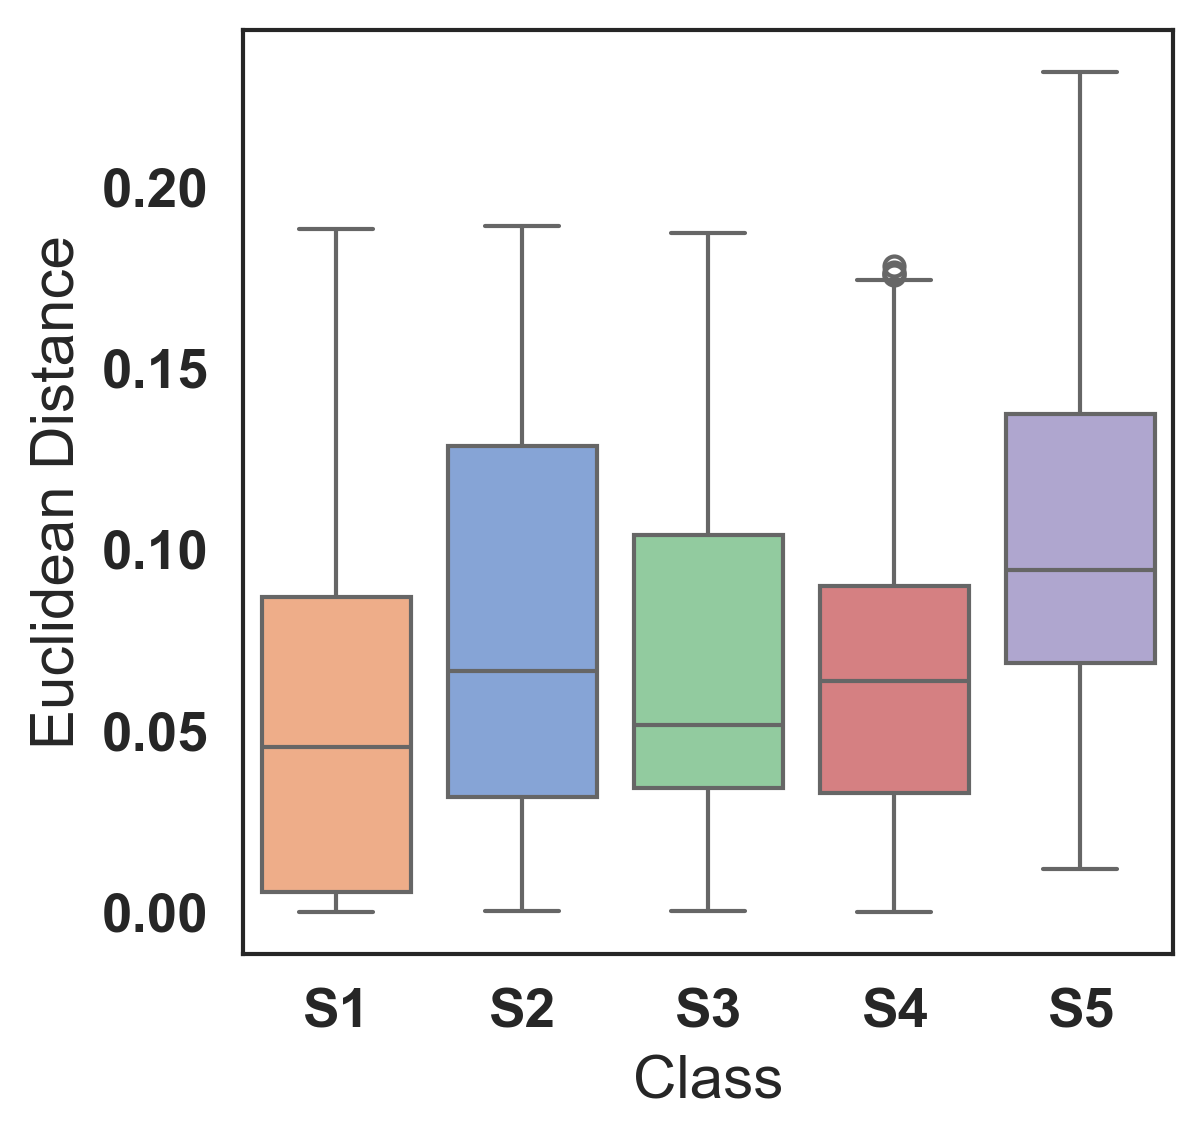

In [28]:
class_list = [
    'S1',
    'S2',
    'S3',
    'S4',
    'S5',
]
colors_5_class = [
    '#88D59A', 
    '#79A1E3', 
    '#E37275',
    '#AB9FD6', 
    '#FFA878', 
]
plt.figure(figsize=(4, 4), dpi=300)
# Use palette instead of color to assign different colors to different categories
sns.boxplot(data=distances_df, 
            order=class_list, 
            palette=colors_5_class
            )
# sns.color_palette(colors_5_class)
# plt.title('Euclidean distance of each test sample to the closest match in training set')
plt.ylabel('Euclidean Distance')
plt.xlabel('Class')
plt.xticks(fontweight='bold')
plt.yticks(fontweight='bold')
plt.show()